In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['axes.grid'] = True

In [46]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, Naive, AutoARIMA, AutoETS, AutoTheta

from mlforecast import MLForecast
from mlforecast.target_transforms import LocalStandardScaler
from lightgbm import LGBMRegressor

from utilsforecast.losses import smape, mae, rmse
from utilsforecast.evaluation import evaluate

from numba import njit

from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1u-hHAVt8VAzMWkAS8l1Zc6XWrtF16rOODL6qYkKXWo4/export?format=csv')
df.ds = pd.to_datetime(df.ds, format='%b %Y')
df

,unique_id,ds,y
0,N1402,1990-01-01,2640.0
1,N1402,1990-02-01,2640.0
2,N1402,1990-03-01,2160.0
3,N1402,1990-04-01,4200.0
4,N1402,1990-05-01,3360.0
...,...,...,...
167557,N2829,2006-07-01,1282.5
167558,N2829,2006-08-01,1261.3
167559,N2829,2006-09-01,1263.4
167560,N2829,2006-10-01,1257.1


#EDA

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 167562 entries, 0 to 167561
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   unique_id  167562 non-null  str           
 1   ds         167562 non-null  datetime64[us]
 2   y          167562 non-null  float64       
dtypes: datetime64[us](1), float64(1), str(1)
memory usage: 4.6 MB


In [5]:
df.describe()

,ds,y
count,167562,167562.000000
mean,1986-12-05 20:37:11.131163,5000.323669
min,1857-01-01 00:00:00,10.000000
25%,1985-01-01 00:00:00,3596.000000
50%,1988-08-01 00:00:00,4850.000000
75%,1991-11-01 00:00:00,6135.000000
max,2006-11-01 00:00:00,86730.000000
std,NaN,2296.363075


In [6]:
print('n_series:', len(np.unique(df.unique_id.values)))

n_series: 1428


In [7]:
np.sort(df['ds'].unique())

array(['1857-01-01T00:00:00.000000', '1857-02-01T00:00:00.000000',
       '1857-03-01T00:00:00.000000', ..., '2006-09-01T00:00:00.000000',
       '2006-10-01T00:00:00.000000', '2006-11-01T00:00:00.000000'],
      shape=(1799,), dtype='datetime64[us]')

In [8]:
df.ds.value_counts()

ds
1990-01-01    1215
1990-02-01    1215
1990-03-01    1215
1990-04-01    1215
1990-05-01    1215
              ... 
1955-08-01       1
1955-09-01       1
1955-10-01       1
1955-11-01       1
1955-12-01       1
Name: count, Length: 1799, dtype: int64

In [9]:
df[df.ds.isin(['1857-01-01', '2006-11-01'])]

,unique_id,ds,y


In [10]:
display(df.unique_id.value_counts())

unique_id
N1879    144
N1881    144
N1882    144
N1883    144
N1884    144
        ... 
N1418     68
N1419     68
N2656     68
N2479     66
N2480     66
Name: count, Length: 1428, dtype: int64

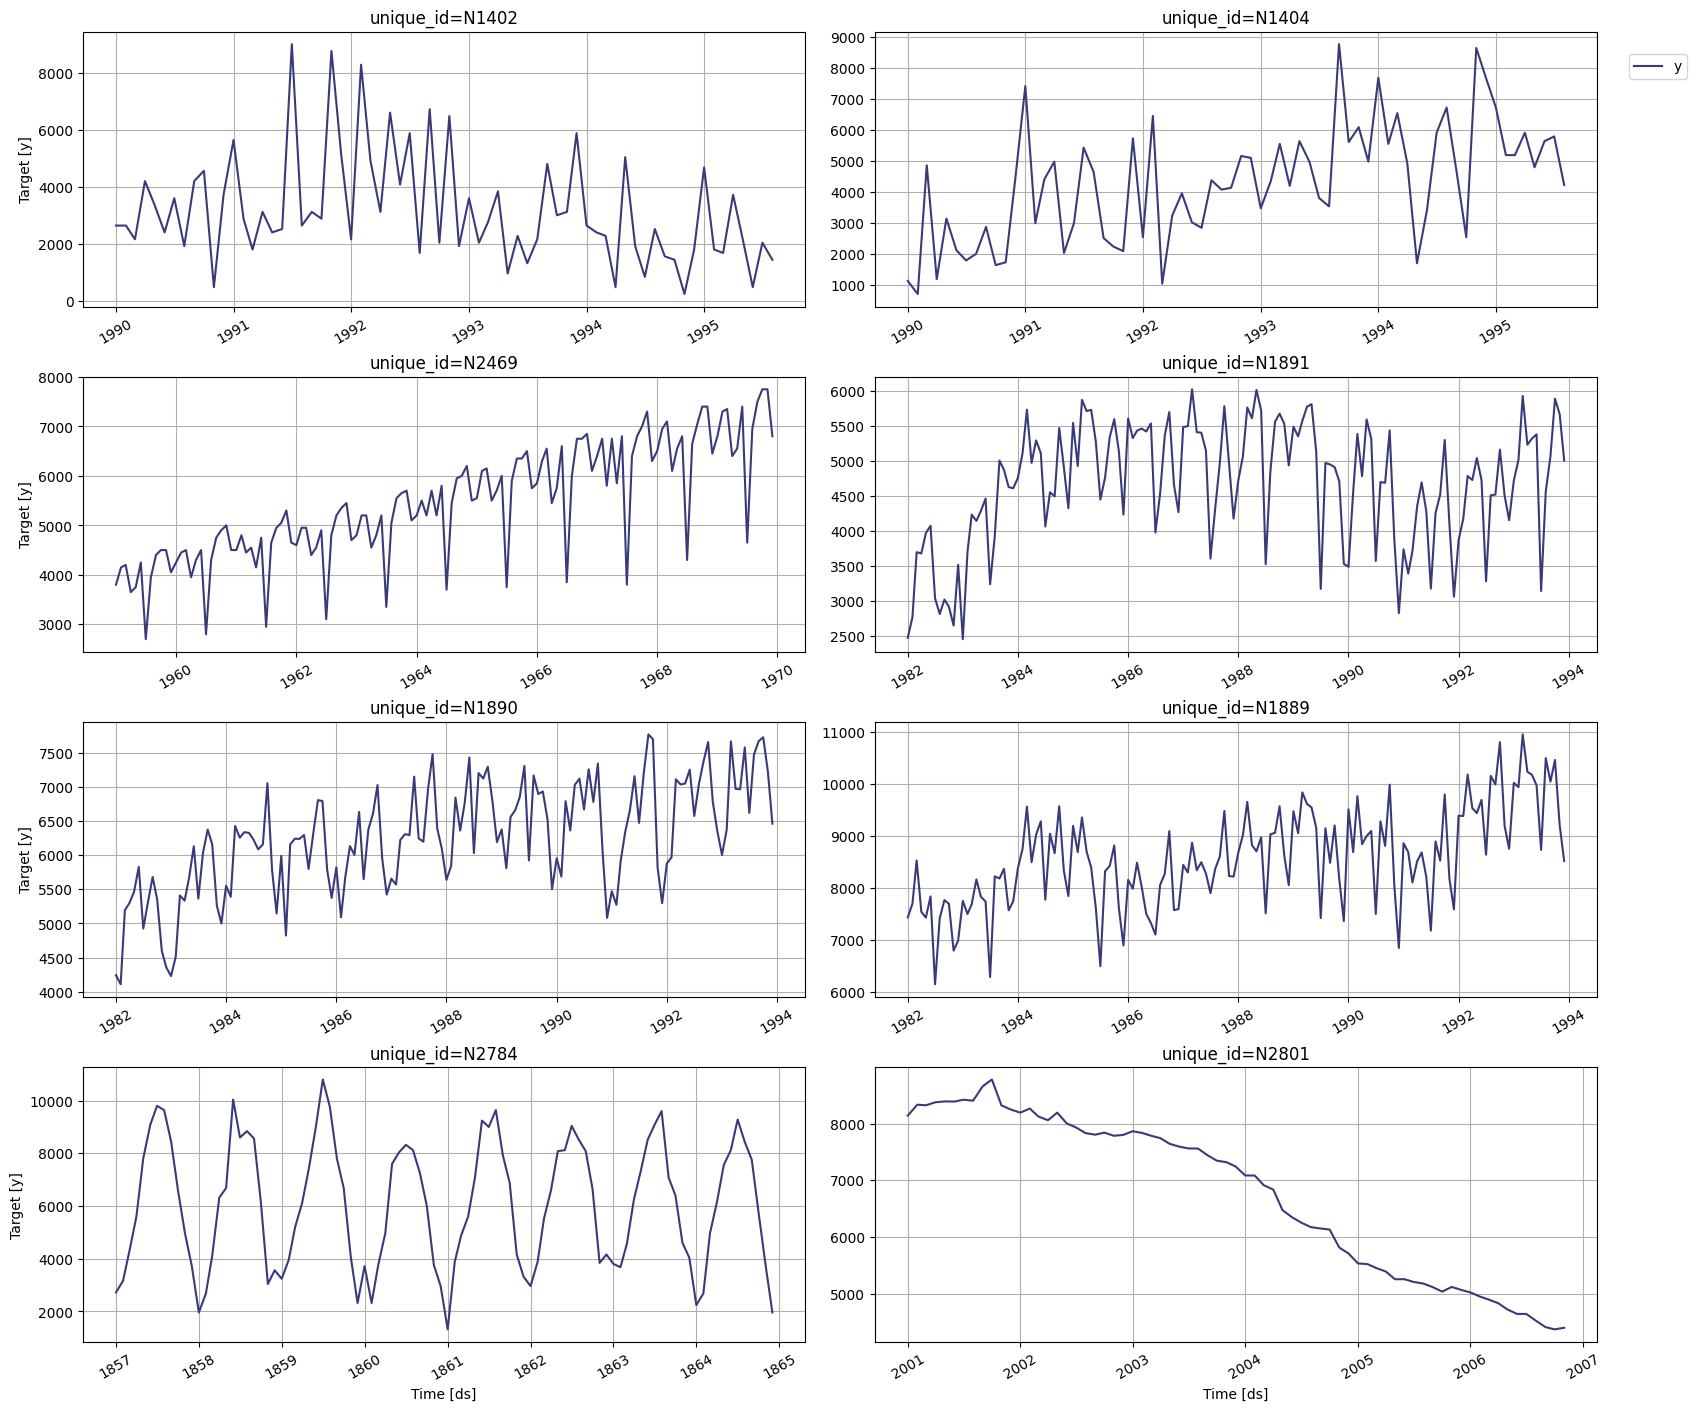

In [11]:
StatsForecast.plot(df, unique_ids=['N1402', 'N1404', 'N2469', #shortest
                                   'N1891', 'N1890', 'N1889', #longest
                                   'N2784', #oldest
                                   'N2801' #newest
                                   ])

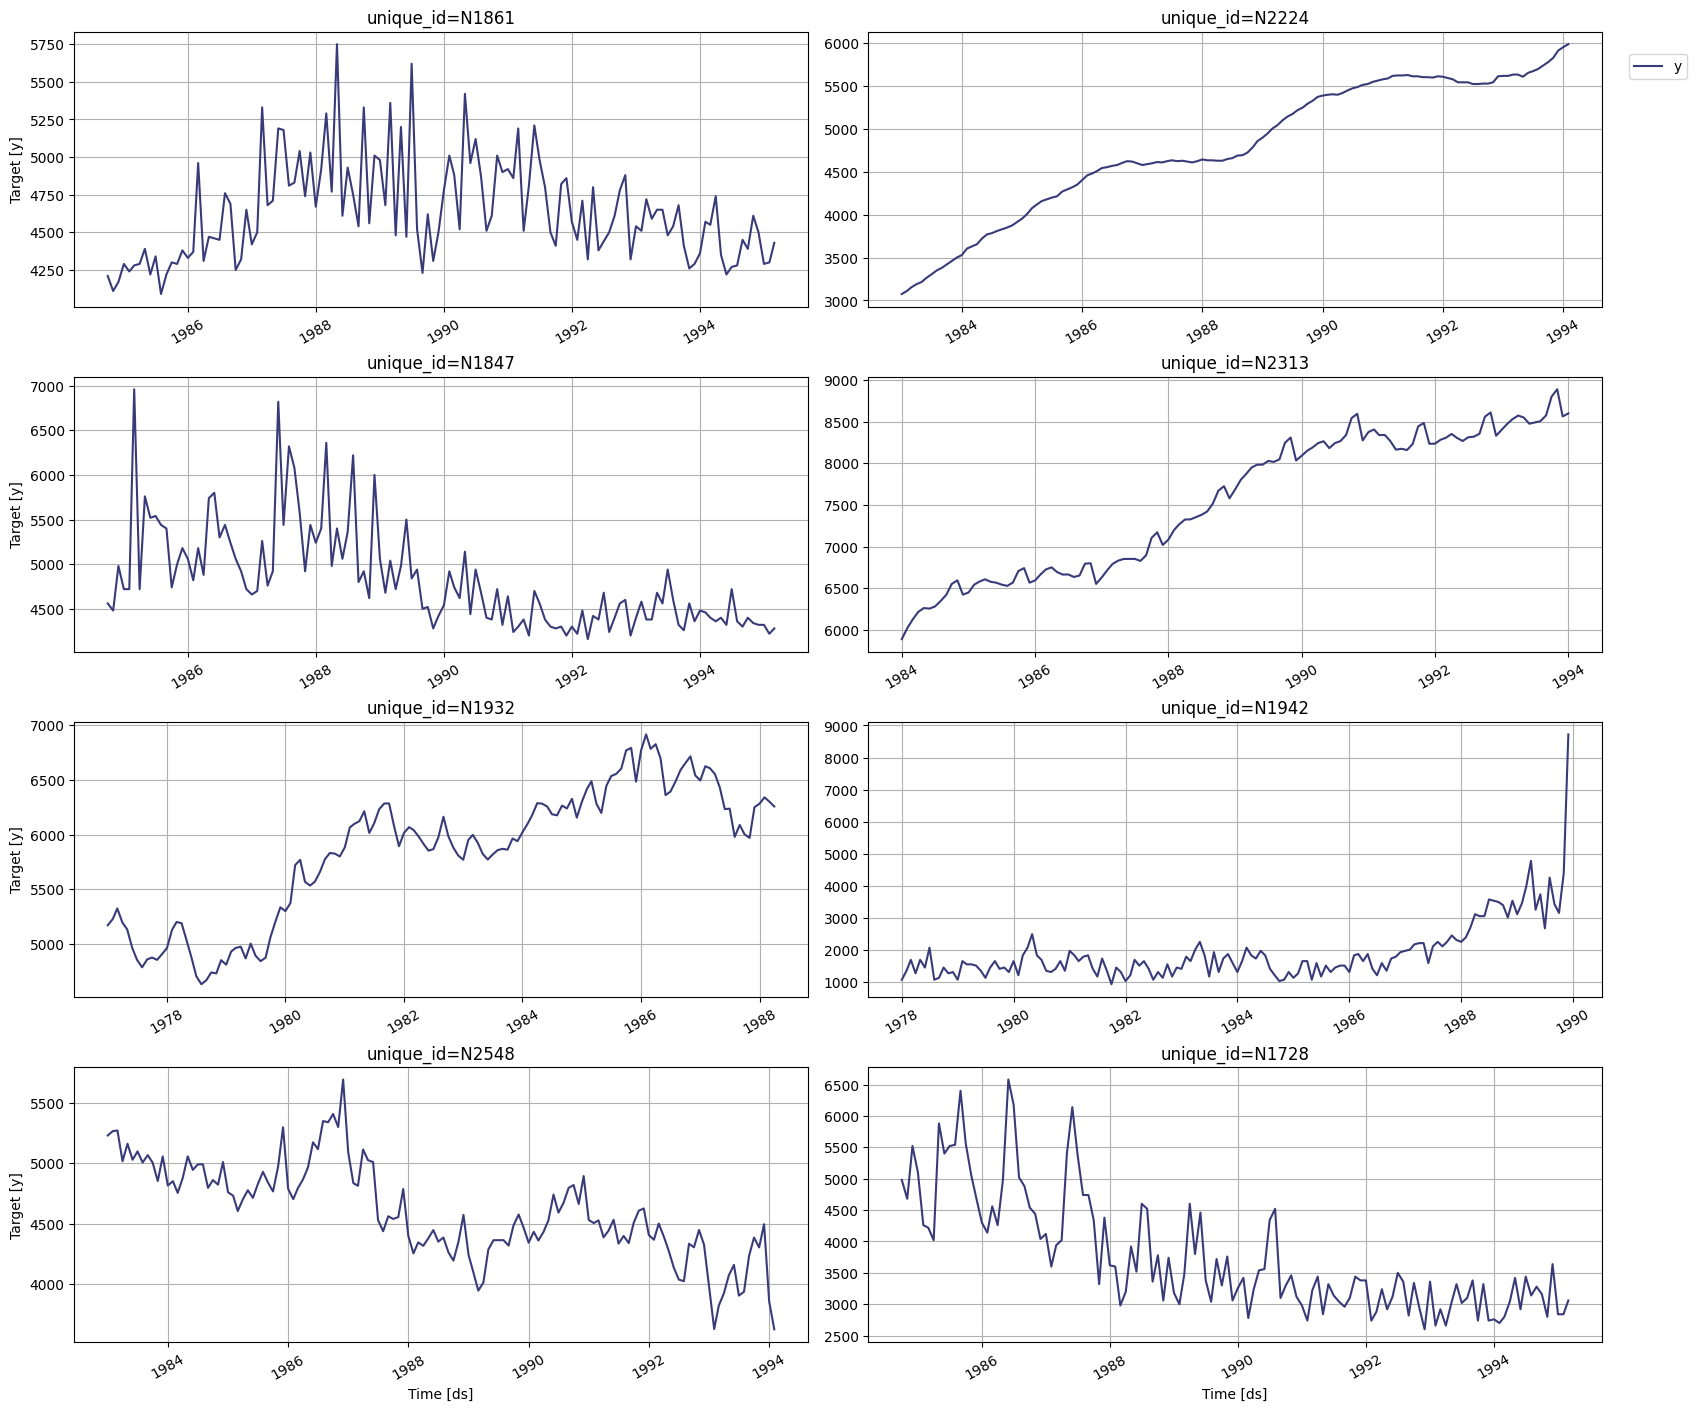

In [12]:
StatsForecast.plot(df)

In [13]:
df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)

In [14]:
series_stats = (
    df.groupby("unique_id")["y"]
      .agg(
          length="size",
          mean="mean",
          std="std"
      )
)

series_stats["cv"] = series_stats["std"] / series_stats["mean"]

In [15]:
def safe_autocorr(x, lag):
    if len(x) <= lag:
        return np.nan
    return x.autocorr(lag=lag)

acf1 = df.groupby("unique_id")["y"].apply(lambda x: safe_autocorr(x, 1))
acf12 = df.groupby("unique_id")["y"].apply(lambda x: safe_autocorr(x, 12))

series_stats["acf1"] = acf1
series_stats["acf12"] = acf12

In [16]:
def seasonal_strength_ratio(x):
    x = x.values
    if len(x) <= 12:
        return np.nan

    naive_err = np.mean(np.abs(x[1:] - x[:-1]))
    snaive_err = np.mean(np.abs(x[12:] - x[:-12]))

    if snaive_err == 0:
        return np.nan

    return naive_err / snaive_err

season_ratio = df.groupby("unique_id")["y"].apply(seasonal_strength_ratio)
series_stats["seasonal_ratio"] = season_ratio

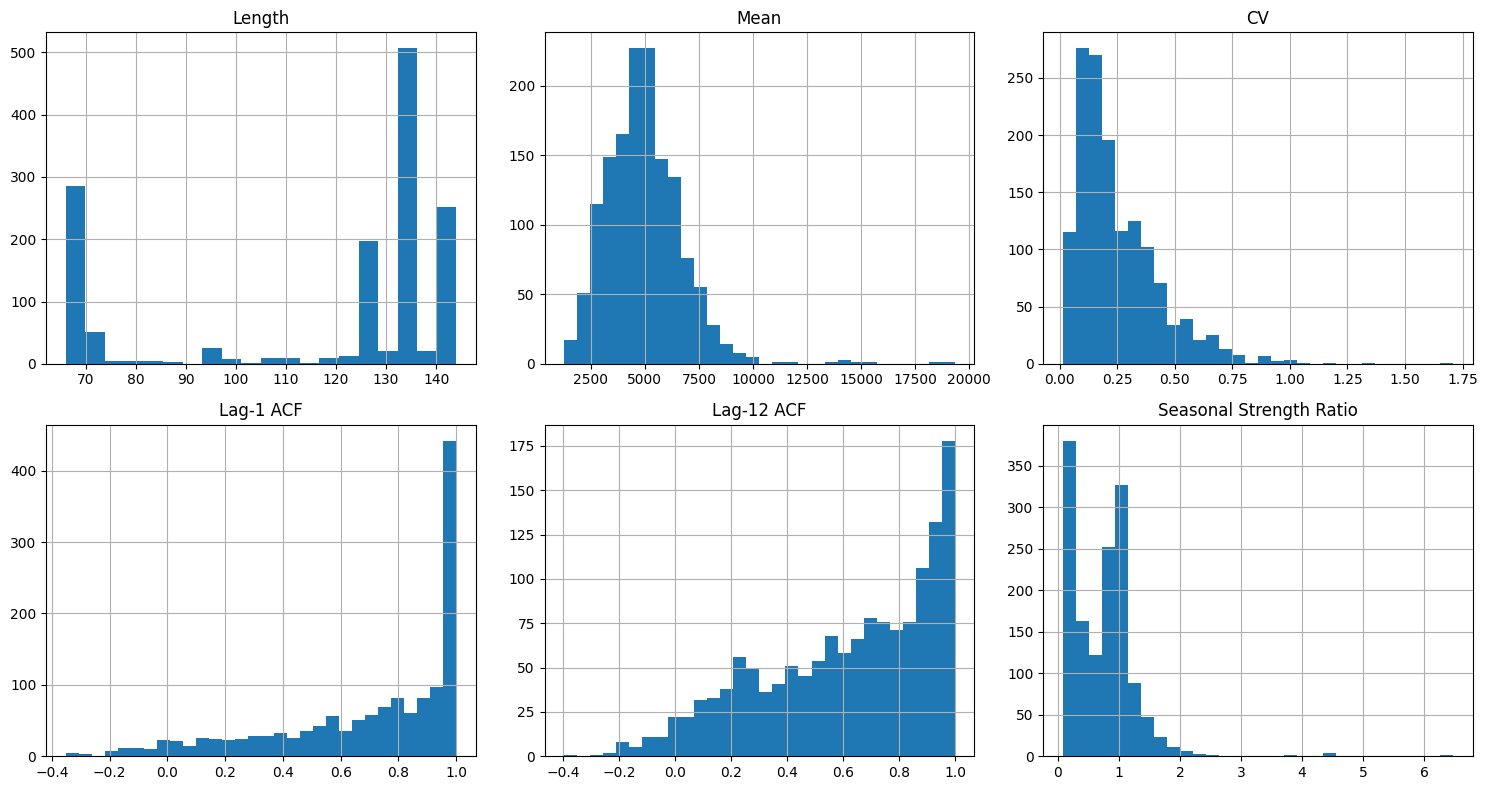

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

series_stats["length"].hist(ax=axes[0,0], bins=20)
axes[0,0].set_title("Length")

series_stats["mean"].hist(ax=axes[0,1], bins=30)
axes[0,1].set_title("Mean")

series_stats["cv"].hist(ax=axes[0,2], bins=30)
axes[0,2].set_title("CV")

series_stats["acf1"].hist(ax=axes[1,0], bins=30)
axes[1,0].set_title("Lag-1 ACF")

series_stats["acf12"].hist(ax=axes[1,1], bins=30)
axes[1,1].set_title("Lag-12 ACF")

series_stats["seasonal_ratio"].hist(ax=axes[1,2], bins=30)
axes[1,2].set_title("Seasonal Strength Ratio")


plt.tight_layout()
plt.show()

- `Temporal span distribution (length)`\
    Bimodal length distribution. Peaks around ~66-70 (5-6 years) and ~132-144 (11-12 years)
    18-months hold out is safe. Almost nothing in between.

- `Mean and coefficient of variation`\
    Strong right-skewed distribution centered around 5k with heavy tail up to 20k.
    log-transform or per-series z-score standardization. Also I am planning to use GBMs so squared-errors learners are scale-dominated and normalization might help alot in here.

    `Coefficient of variation` tells lower values indicate less dispersion. CV 0.0 - 0.25 relative variation is low but still this is conditioned on mean. This plot tells relative stability and hence one useful series level feature for splits. Many series are stable relative to their scale though some series are highly volatile since we can see long tail up to 1.75

- `Lag 1 ACF (Short-term persistance)`\
    Very strong auto-correlation compared lag 1 -> strong short term persistance.\
    We can assume <mark>Naive</mark> is strong. Lag1 feature is strong. And differencing would destroy this signal.

- `Lag 12 ACF (Long-term persistance)`\
    Wide distribution. Many series have strong yearly correlation. Still many series have weak, noisy seasonality. <mark>Seasonal Naive</mark> will be strong for many series and weak for many others.\
    `ETS` or `Theta` might fit good in here. For trees lag12 feature.

- `Seasonal Strength Ratio`\
    ratio = naive_error / seasonal_naive_error\
    ratio > 1 (seasonal naive better)\
    ratio ~ 1 (weak seasonality)\
    ratio < 1 (seasonal naive worse)\

    Right skewed with long tail up to 4.5 meaning some small amout of series have very strong seasonality.\
    Half of the series are better fit for <mark>Naive</mark>.\
    Another half of the series are better fit for <mark>Seasonal Naive</mark>.\
    Heterogeneous series

###Summary of data characteristics
- Strong persistance (lag1)
- Mixed seasonality (lag12 + seasonal ratio)
- Two dominant series length
- Heterogeneous scale and Volatility across series


###Model Assumptions
- Seasonal Naive
- Naive
- AutoETS and AutoTheta
- Global ML must
    - scale per series (z-score)
    - series-level metadata features
    - avoid heavy differencing
    - small lags

## Train / Test Split

18 observations

In [18]:
HORIZON = 18

# last dates per series
last_dates = df.groupby('unique_id')['ds'].max().reset_index()
last_dates.columns = ['unique_id', 'last_date']
df = df.merge(last_dates, on='unique_id')

# count months from most recent date till first date for each series
df['months_from_end'] = df.groupby('unique_id').cumcount(ascending=False)
df

,unique_id,ds,y,last_date,months_from_end
0,N1402,1990-01-01,2640.0,1995-08-01,67
1,N1402,1990-02-01,2640.0,1995-08-01,66
2,N1402,1990-03-01,2160.0,1995-08-01,65
3,N1402,1990-04-01,4200.0,1995-08-01,64
4,N1402,1990-05-01,3360.0,1995-08-01,63
...,...,...,...,...,...
167557,N2829,2006-07-01,1282.5,2006-11-01,4
167558,N2829,2006-08-01,1261.3,2006-11-01,3
167559,N2829,2006-09-01,1263.4,2006-11-01,2
167560,N2829,2006-10-01,1257.1,2006-11-01,1


In [19]:
train = df[df['months_from_end'] >= HORIZON].copy()
test = df[df['months_from_end'] < HORIZON].copy()

train = train[['unique_id', 'ds', 'y']]
test = test[['unique_id', 'ds', 'y']]

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train series: {train['unique_id'].nunique()}")
print(f"Test series: {test['unique_id'].nunique()}")


Train shape: (141858, 3)
Test shape: (25704, 3)
Train series: 1428
Test series: 1428


## Baselines
As findings from EDA, Naive and SeasonalNaive will explains best for these multiple series as a baseline

In [21]:
baseline_models = [
    SeasonalNaive(season_length=12),
    Naive()
]

sf_baselines = StatsForecast(
    models=baseline_models,
    freq='MS',
    n_jobs=-1
)

# fitted per-series
# scaling doesn't matter now in here yet
sf_baselines.fit(train)

StatsForecast(models=[SeasonalNaive,Naive])

In [22]:
forecasts_baselines = sf_baselines.predict(h=HORIZON)

In [23]:
eval_baseline_df = forecasts_baselines.merge(
    test,
    on=['unique_id', 'ds'],
    how='left'
)

In [24]:
scores_baseline = evaluate(
    eval_baseline_df,
    metrics=[smape],   # sMAPE ∈ [0, 2] where closer to 0 is better
    models=['SeasonalNaive', 'Naive']
)

In [25]:
stat_models = [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12),
    AutoTheta(season_length=12)
]

sf_stats = StatsForecast(
    models=stat_models,
    freq='MS',
    n_jobs=-1
)

sf_stats.fit(train)

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/statsforecast/arima.py:1519: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/statsforecast/arima.py:1519: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/statsforecast/arima.py:1519: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(


StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta])

In [26]:
forecasts_stats = sf_stats.predict(h=HORIZON)

In [27]:
eval_stats_df = forecasts_stats.merge(
    test,
    on=['unique_id', 'ds'],
    how='left'
)

In [28]:
scores_stats = evaluate(
    eval_stats_df,
    metrics=[smape],
    models=['AutoARIMA', 'AutoETS', 'AutoTheta']
)

In [29]:
scores_stats_and_baselines = scores_baseline.merge(
    scores_stats,
    on='unique_id',
    how='inner'
)

scores_stats_and_baselines

,unique_id,metric_x,SeasonalNaive,Naive,metric_y,AutoARIMA,AutoETS,AutoTheta
0,N1402,smape,0.351044,0.277484,smape,0.381421,0.381513,0.361210
1,N1403,smape,0.309464,0.316648,smape,0.193649,0.193398,0.150630
2,N1404,smape,0.178645,0.127946,smape,0.172343,0.153772,0.158427
3,N1405,smape,0.283145,0.229269,smape,0.144252,0.157244,0.149719
4,N1406,smape,0.173078,0.131440,smape,0.115301,0.154577,0.094124
...,...,...,...,...,...,...,...,...
1423,N2825,smape,0.008389,0.011122,smape,0.016284,0.012527,0.012910
1424,N2826,smape,0.108587,0.050102,smape,0.056777,0.053709,0.063289
1425,N2827,smape,0.081936,0.054994,smape,0.010030,0.011756,0.010205
1426,N2828,smape,0.014536,0.010701,smape,0.010701,0.010701,0.009978


#### Evaluation baselines + statistical models

In [30]:
models_stats_and_baselines = [
    'Naive',
    'SeasonalNaive',
    'AutoARIMA',
    'AutoETS',
    'AutoTheta'
]

mean_smape = scores_stats_and_baselines[models_stats_and_baselines].mean().sort_values()
median_smape = scores_stats_and_baselines[models_stats_and_baselines].median().sort_values()

print("Mean sMAPE")
print(mean_smape)

print("\nMedian sMAPE")
print(median_smape)

winners_all = scores_stats_and_baselines[models_stats_and_baselines].idxmin(axis=1)
win_counts_all = winners_all.value_counts().sort_values(ascending=False)

print("\nWin counts")
print(win_counts_all)

Mean sMAPE
AutoETS          0.070790
AutoTheta        0.074840
AutoARIMA        0.076132
SeasonalNaive    0.086169
Naive            0.090904
dtype: float64

Median sMAPE
AutoARIMA        0.044711
AutoETS          0.045820
AutoTheta        0.046400
Naive            0.055034
SeasonalNaive    0.059803
dtype: float64

Win counts
AutoARIMA        387
AutoTheta        335
AutoETS          332
Naive            200
SeasonalNaive    174
Name: count, dtype: int64


## Machine Learning

Global Model: Fit one model on all series pulled together.

In [252]:
train = df[df['months_from_end'] >= HORIZON].copy()
test = df[df['months_from_end'] < HORIZON].copy()

train = train[['unique_id', 'ds', 'y']]
test = test[['unique_id', 'ds', 'y']]

train = train.sort_values(["unique_id", "ds"]).reset_index(drop=True)
test  = test.sort_values(["unique_id", "ds"]).reset_index(drop=True)

In [253]:
mlf = MLForecast(
    models=[
        # leaf level regressions
        LGBMRegressor(linear_tree=True)
    ],
    freq='MS',
    lags=[1, 2, 3, 4, 5, 6, 12],
    lag_transforms={
        6: [(rolling_mean, 6), (rolling_std, 6), (rolling_min, 6), (rolling_max, 6)],
        12: [(rolling_mean, 12), (rolling_std, 12), (rolling_min, 12), (rolling_max, 12)],
    },
    # target_transforms=[LocalStandardScaler()],
    date_features=['month', 'year'],
)

mlf.fit(train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3949
[LightGBM] [Info] Number of data points in the train set: 109014, number of used features: 17
[LightGBM] [Info] Start training from score 5025.096224


MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag12', 'rolling_mean_lag6_window_size6', 'rolling_std_lag6_window_size6', 'rolling_min_lag6_window_size6', 'rolling_max_lag6_window_size6', 'rolling_mean_lag12_window_size12', 'rolling_std_lag12_window_size12', 'rolling_min_lag12_window_size12', 'rolling_max_lag12_window_size12'], date_features=['month', 'year'], num_threads=1)

In [254]:
mlf_forecasts = mlf.predict(
    h=HORIZON,
)
mlf_forecasts

,unique_id,ds,LGBMRegressor
0,N1402,1994-03-01,2865.614138
1,N1402,1994-04-01,2877.567462
2,N1402,1994-05-01,2556.996288
3,N1402,1994-06-01,2819.611854
4,N1402,1994-07-01,2902.275567
...,...,...,...
25699,N2829,2006-07-01,1324.806001
25700,N2829,2006-08-01,1313.079869
25701,N2829,2006-09-01,1292.339326
25702,N2829,2006-10-01,1228.572362


#### Feature Importance LGBM

In [255]:
feature_names = mlf.ts.features_order_

lgbm_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': mlf.models_['LGBMRegressor'].feature_importances_
}).sort_values('importance', ascending=False)

In [265]:
lgbm_imp

,feature,importance
0,lag1,349
6,lag12,279
1,lag2,258
16,year,243
2,lag3,215
15,month,188
9,rolling_min_lag6_window_size6,156
13,rolling_min_lag12_window_size12,150
8,rolling_std_lag6_window_size6,146
3,lag4,143


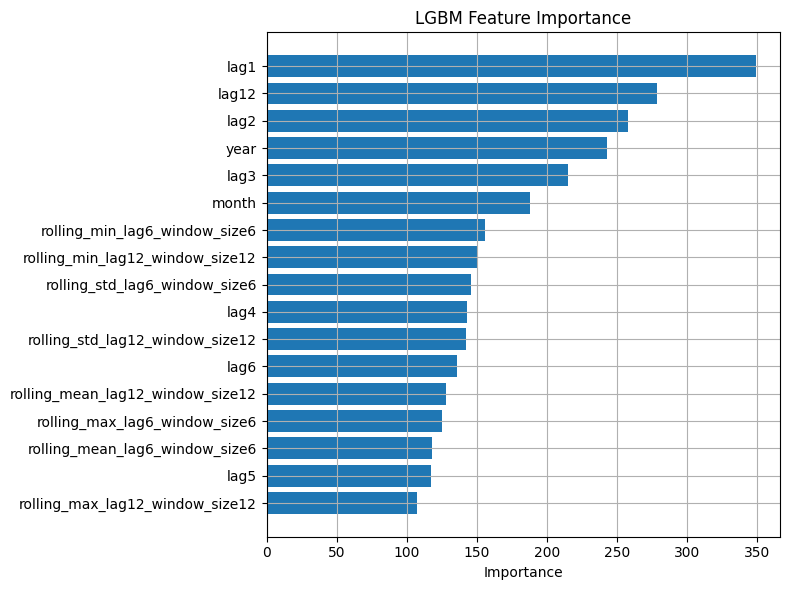

In [256]:
top_k = 20

df_plot = lgbm_imp.head(top_k).sort_values('importance')

plt.figure(figsize=(8, 6))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Importance')
plt.title('LGBM Feature Importance')
plt.tight_layout()
plt.show()

In [257]:
eval_ml = mlf_forecasts.merge(
    test,
    on=['unique_id', 'ds'],
    how='left'
)

eval_ml

,unique_id,ds,LGBMRegressor,y
0,N1402,1994-03-01,2865.614138,2280.0
1,N1402,1994-04-01,2877.567462,480.0
2,N1402,1994-05-01,2556.996288,5040.0
3,N1402,1994-06-01,2819.611854,1920.0
4,N1402,1994-07-01,2902.275567,840.0
...,...,...,...,...
25699,N2829,2006-07-01,1324.806001,1282.5
25700,N2829,2006-08-01,1313.079869,1261.3
25701,N2829,2006-09-01,1292.339326,1263.4
25702,N2829,2006-10-01,1228.572362,1257.1


In [258]:
scores_ml = evaluate(
    eval_ml.rename(columns={'LGBMRegressor': 'LightGBM'}),
    metrics=[smape],
    models=['LightGBM']
)

scores_ml

,unique_id,metric,LightGBM
0,N1402,smape,0.352953
1,N1403,smape,0.225727
2,N1404,smape,0.139427
3,N1405,smape,0.177551
4,N1406,smape,0.105848
...,...,...,...
1423,N2825,smape,0.053844
1424,N2826,smape,0.015601
1425,N2827,smape,0.019723
1426,N2828,smape,0.030471


In [259]:
scores_all = scores_stats_and_baselines.merge(
    scores_ml,
    on='unique_id',
    how='inner'
)

scores_all

,unique_id,metric_x,SeasonalNaive,Naive,metric_y,AutoARIMA,AutoETS,AutoTheta,metric,LightGBM
0,N1402,smape,0.351044,0.277484,smape,0.381421,0.381513,0.361210,smape,0.352953
1,N1403,smape,0.309464,0.316648,smape,0.193649,0.193398,0.150630,smape,0.225727
2,N1404,smape,0.178645,0.127946,smape,0.172343,0.153772,0.158427,smape,0.139427
3,N1405,smape,0.283145,0.229269,smape,0.144252,0.157244,0.149719,smape,0.177551
4,N1406,smape,0.173078,0.131440,smape,0.115301,0.154577,0.094124,smape,0.105848
...,...,...,...,...,...,...,...,...,...,...
1423,N2825,smape,0.008389,0.011122,smape,0.016284,0.012527,0.012910,smape,0.053844
1424,N2826,smape,0.108587,0.050102,smape,0.056777,0.053709,0.063289,smape,0.015601
1425,N2827,smape,0.081936,0.054994,smape,0.010030,0.011756,0.010205,smape,0.019723
1426,N2828,smape,0.014536,0.010701,smape,0.010701,0.010701,0.009978,smape,0.030471


In [260]:
models_all = [
    'Naive',
    'SeasonalNaive',
    'AutoARIMA',
    'AutoETS',
    'AutoTheta',
    'LightGBM'
]

mean_smape = scores_all[models_all].mean().sort_values()
median_smape = scores_all[models_all].median().sort_values()

print("Mean sMAPE")
print(mean_smape)

print("\nMedian sMAPE")
print(median_smape)

winners_all = scores_all[models_all].idxmin(axis=1)
win_counts_all = winners_all.value_counts().sort_values(ascending=False)

print("\nWin counts")
print(win_counts_all)

Mean sMAPE
AutoETS          0.070790
AutoTheta        0.074840
AutoARIMA        0.076132
LightGBM         0.077739
SeasonalNaive    0.086169
Naive            0.090904
dtype: float64

Median sMAPE
AutoARIMA        0.044711
AutoETS          0.045820
AutoTheta        0.046400
LightGBM         0.052073
Naive            0.055034
SeasonalNaive    0.059803
dtype: float64

Win counts
AutoARIMA        337
AutoETS          293
AutoTheta        281
LightGBM         217
Naive            161
SeasonalNaive    139
Name: count, dtype: int64


Tree-based ML models underperform classical forecasting methods on M3 monthly data.

- short time series
- limited exogenous variables
- statistical models capture trend/seasonality better

> AutoETS provides the best overall performance by mean sMAPE, while AutoARIMA wins the highest number of individual series.

#### Visualising worse series for LGBM

In [290]:
worst_ids = (
    (eval_ml['y'] - eval_ml['LGBMRegressor'])
    .abs()
    .groupby(eval_ml['unique_id'])
    .mean()
    .nlargest(32)
)

In [283]:
worse_list = worst_ids.index.tolist()

In [ ]:
for i in range(4):
    worst_plots = worse_list[i*8:(i+1)*8]

    print(f"\nBatch {i+1}/4:", worst_plots)
    StatsForecast.plot(df, unique_ids=worst_plots)


Batch 1/4: ['N2090', 'N2602', 'N2105', 'N1986', 'N2506', 'N1985', 'N2493', 'N2665']

Batch 2/4: ['N1413', 'N2136', 'N2597', 'N2752', 'N2637', 'N2758', 'N1642', 'N2598']

Batch 3/4: ['N2748', 'N1488', 'N2491', 'N2603', 'N2479', 'N1705', 'N1431', 'N2649']

Batch 4/4: ['N1460', 'N1415', 'N2658', 'N2769', 'N2457', 'N1637', 'N2605', 'N2600']


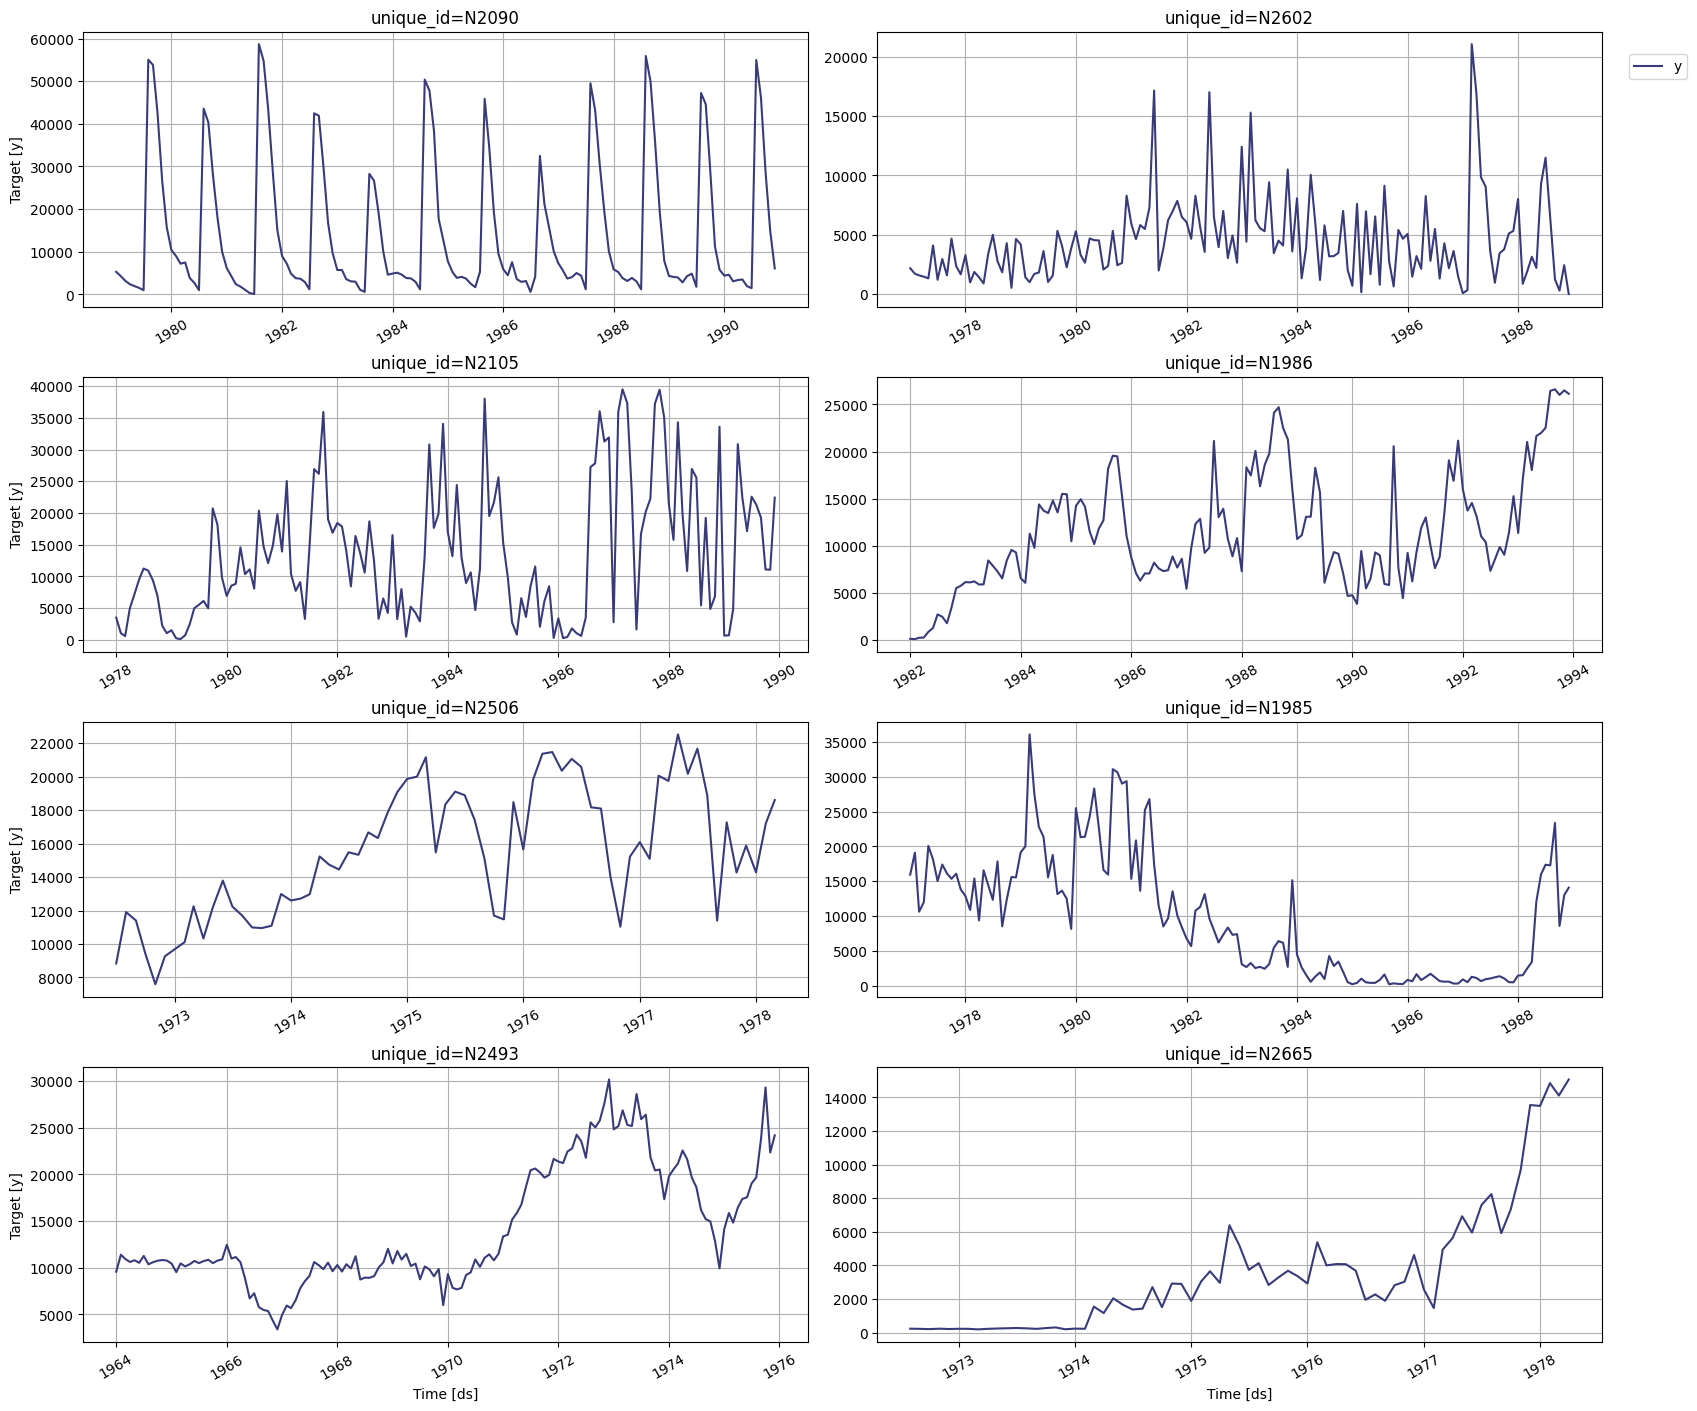

In [286]:
StatsForecast.plot(df, unique_ids=['N2090', 'N2602', 'N2105', 'N1986', 'N2506', 'N1985', 'N2493', 'N2665'])

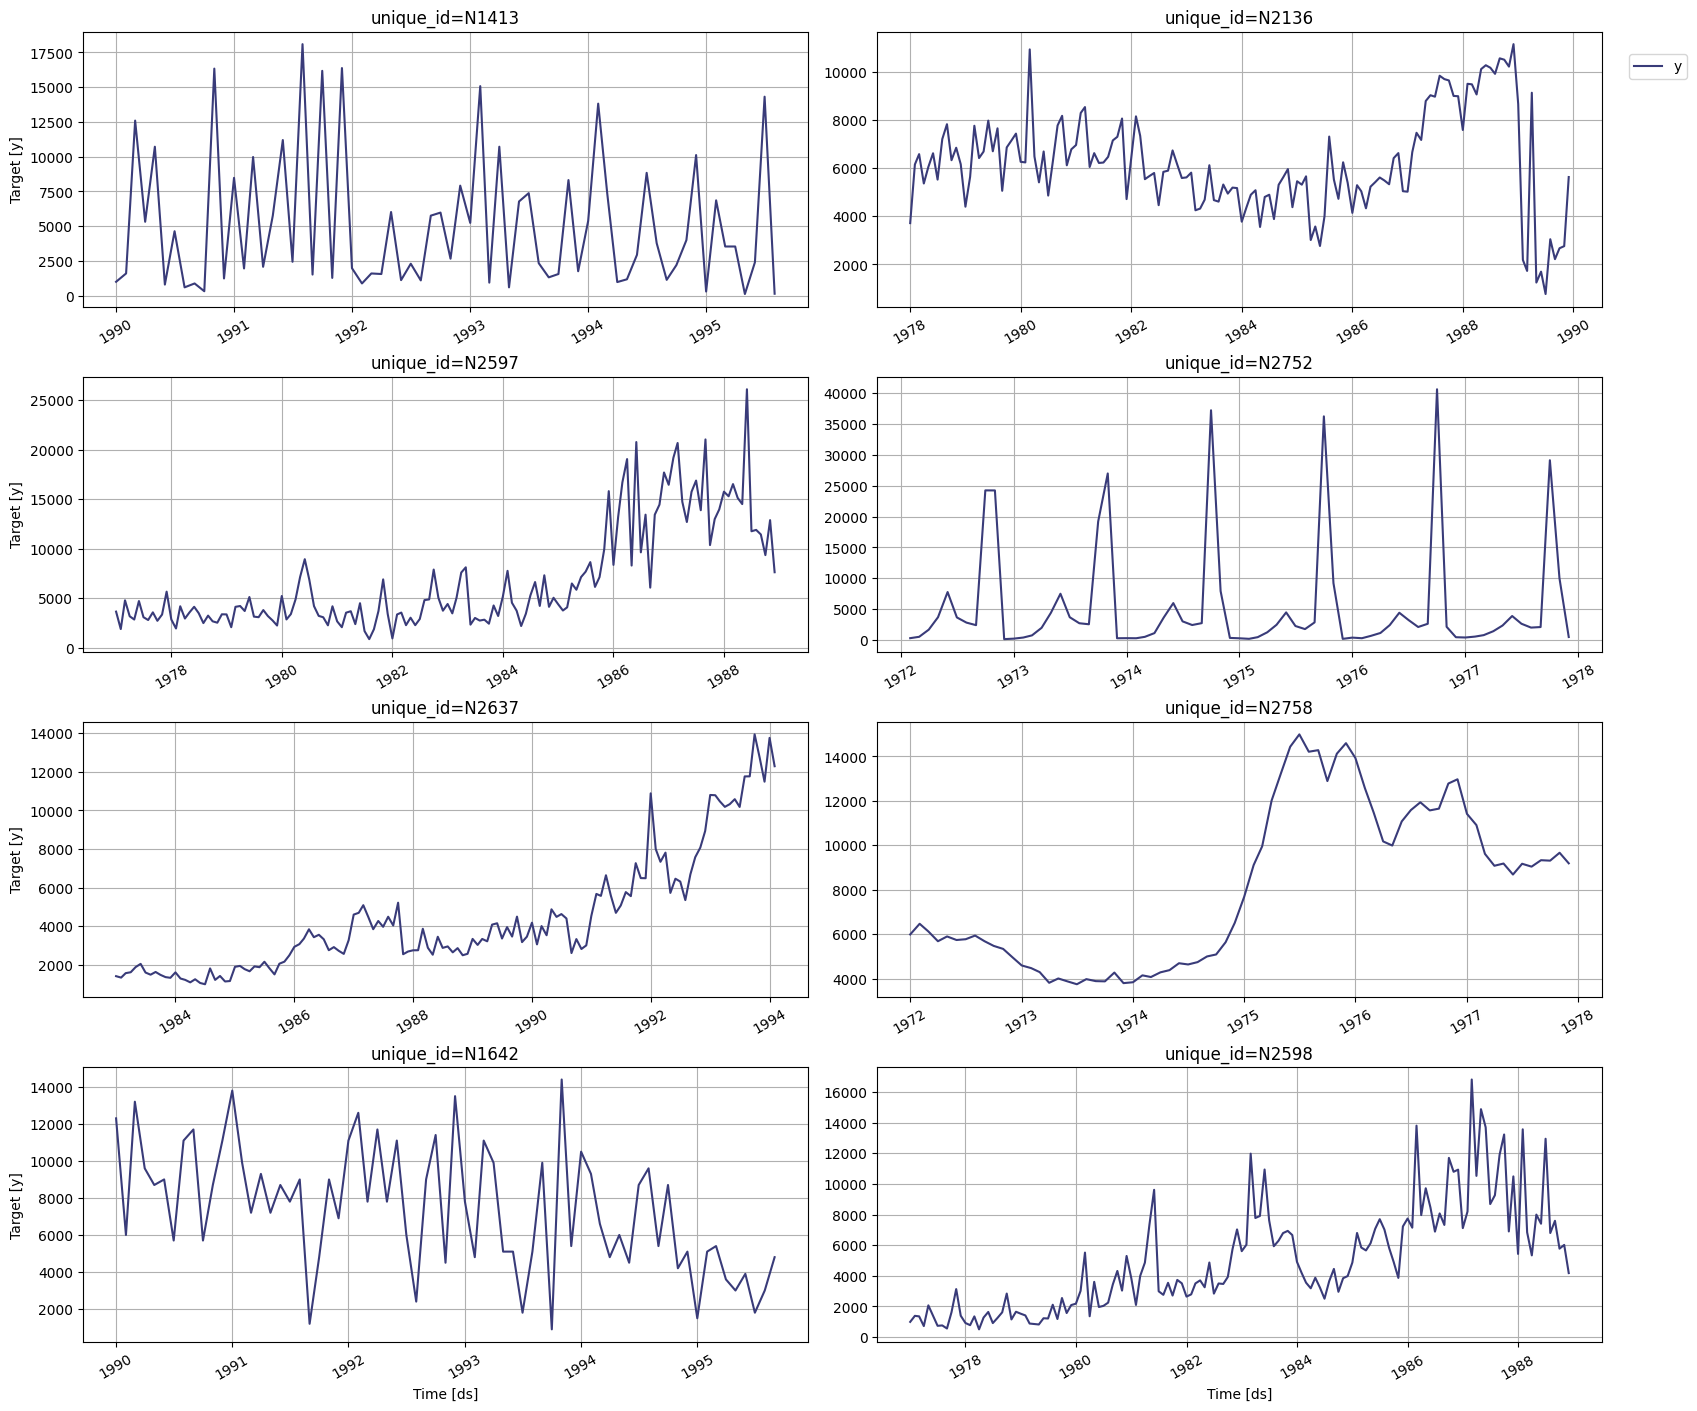

In [287]:
StatsForecast.plot(df, unique_ids=['N1413', 'N2136', 'N2597', 'N2752', 'N2637', 'N2758', 'N1642', 'N2598'])

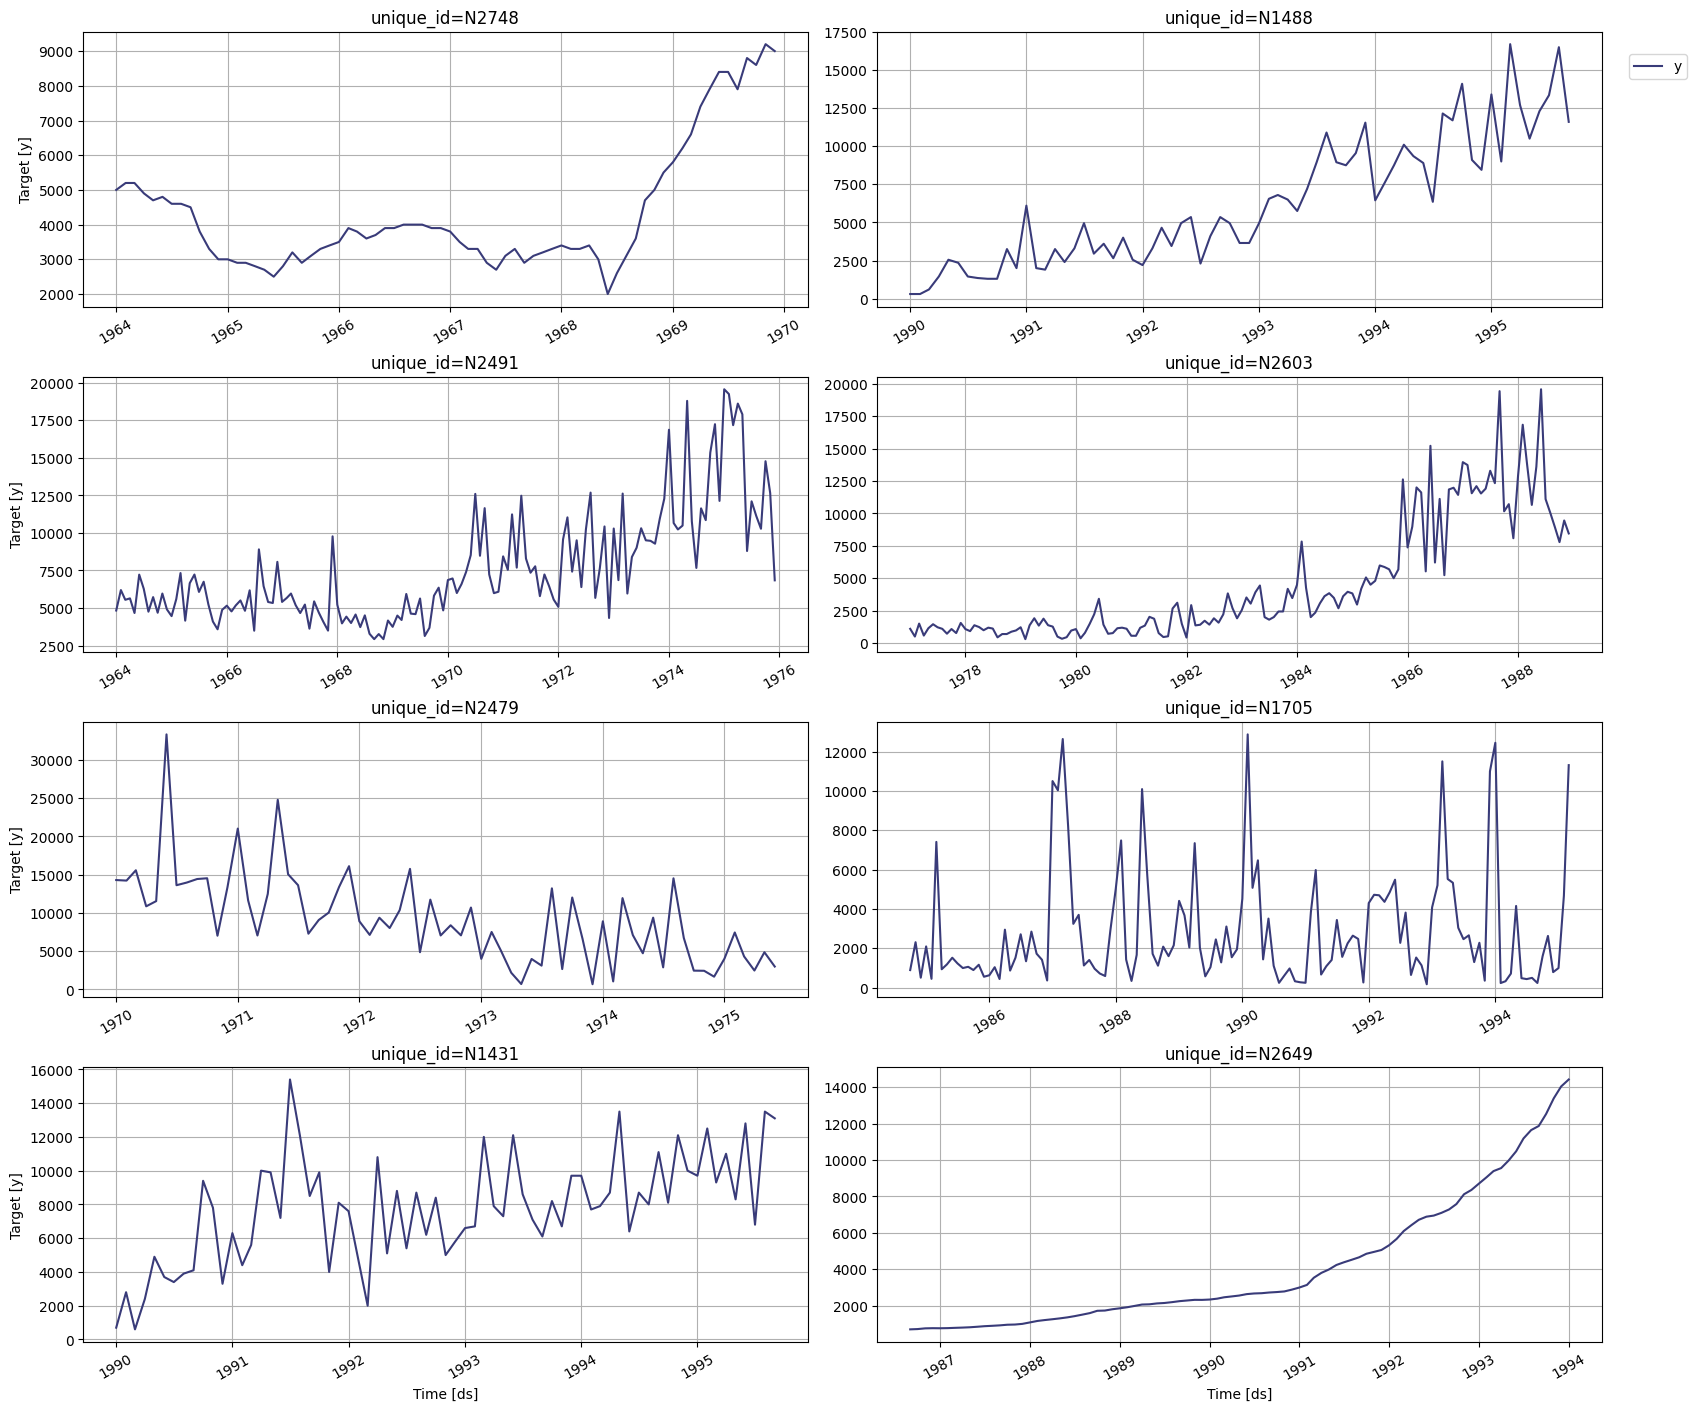

In [288]:
StatsForecast.plot(df, unique_ids=['N2748', 'N1488', 'N2491', 'N2603', 'N2479', 'N1705', 'N1431', 'N2649'])

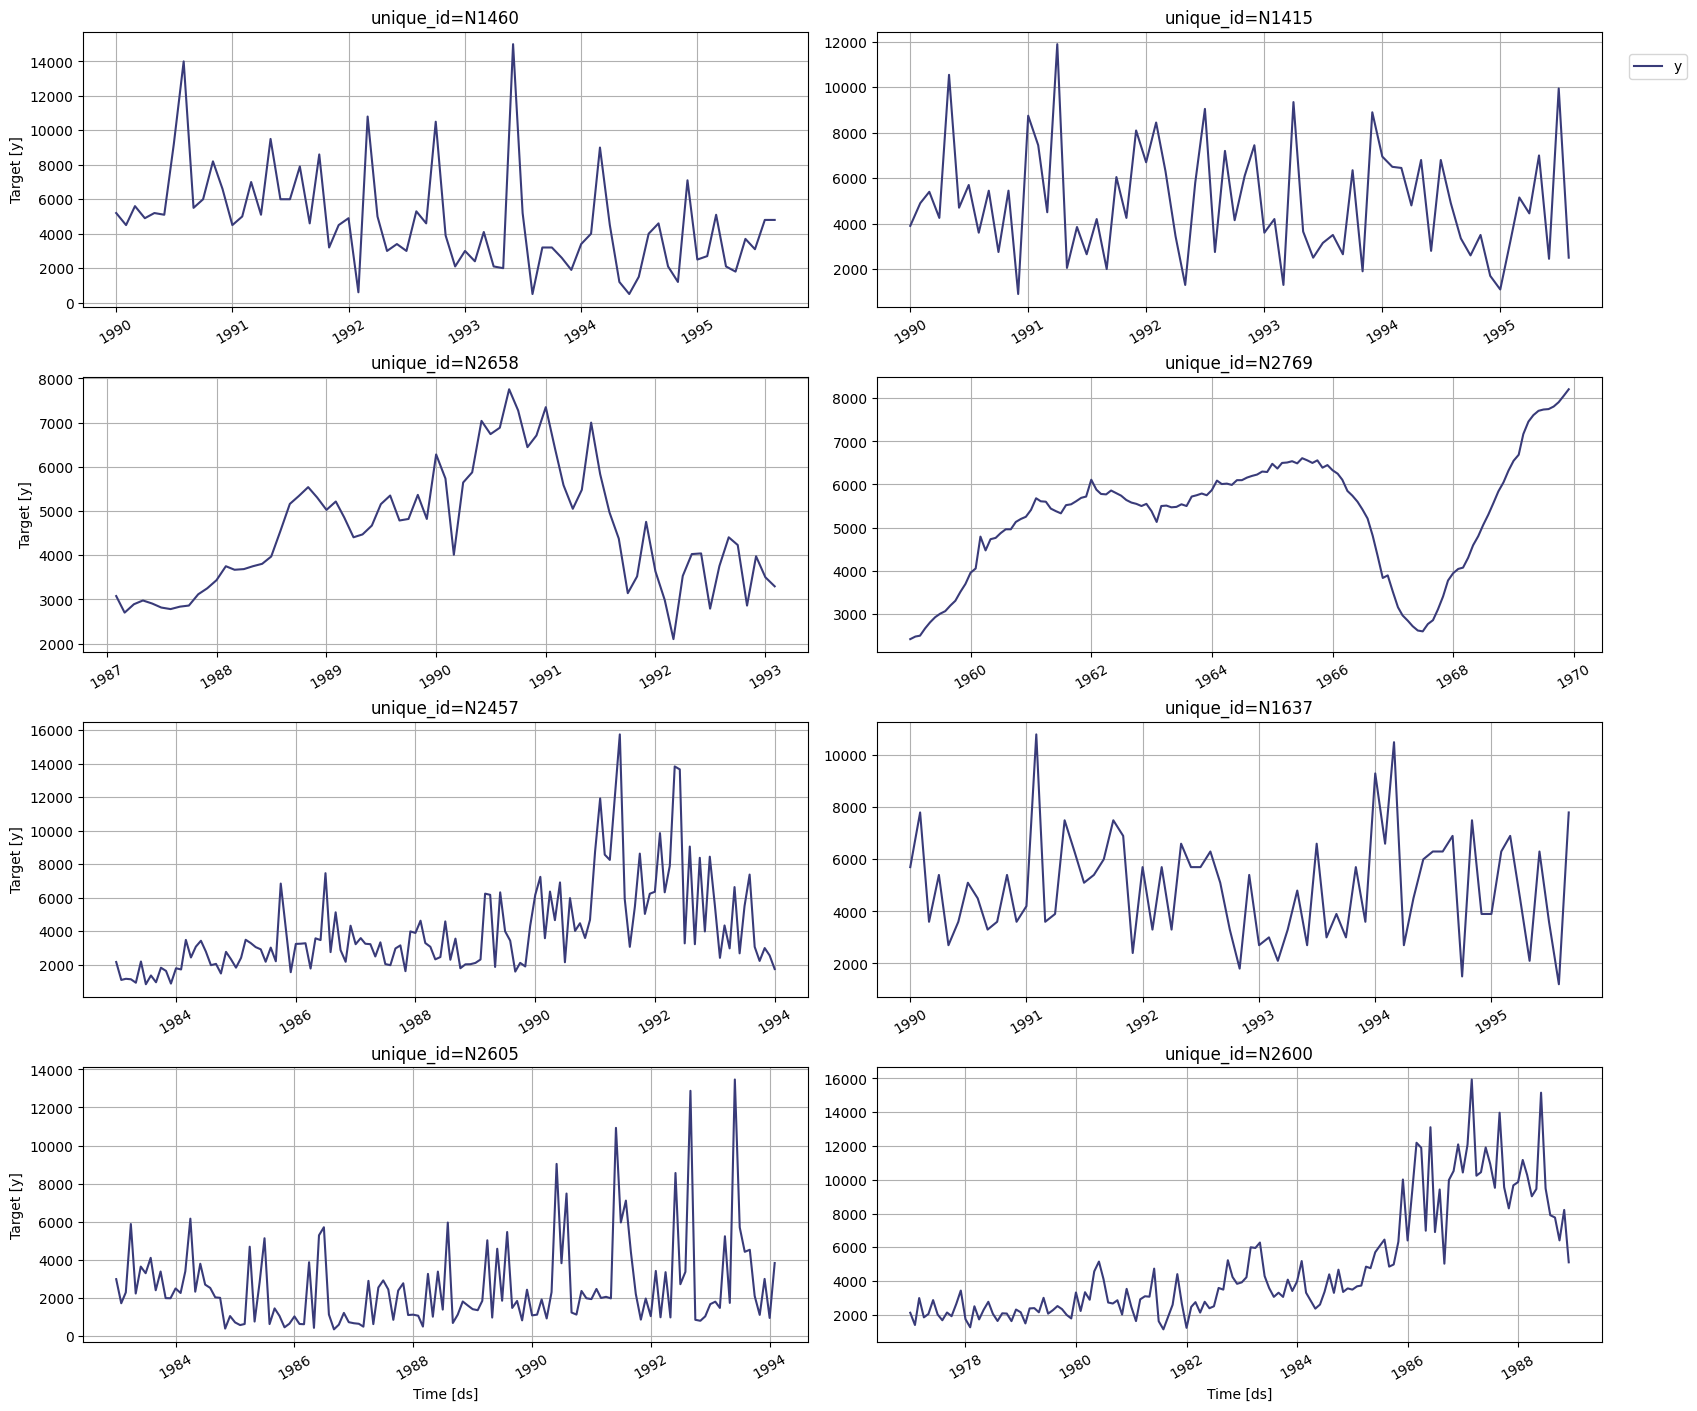

In [289]:
StatsForecast.plot(df, unique_ids=['N1460', 'N1415', 'N2658', 'N2769', 'N2457', 'N1637', 'N2605', 'N2600'])